In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, colors
from matplotlib.cbook import boxplot_stats
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from scipy import stats

In [2]:
df = pd.read_csv("./datos/heart.csv")

In [3]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Análisis multivariante

Seleccionamos las variables numéricas, para realizar una análisis multivariante de valores atípicos, que nos confirme 

In [4]:
features = ["trtbps","chol","age","thalachh"]

## Boxplot

<AxesSubplot: >

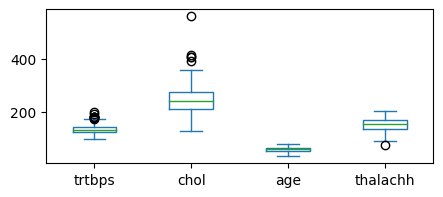

In [5]:
df[features].plot.box(figsize=(5,2))

Imprimimos los valores outliers

In [6]:
[print(feature, stats["fliers"]) for feature, stats in zip(features, boxplot_stats(df[features]))]

trtbps [172 178 180 180 200 174 192 178 180]
chol [417 564 394 407 409]
age []
thalachh [71]


[None, None, None, None]

## Reachability Plot

Text(0.5, 1.0, 'Reachability Plot')

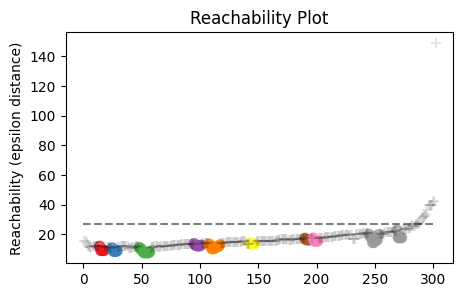

In [7]:
clust= OPTICS().fit(df[features])

space = np.arange(len(df))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

norm = colors.Normalize(vmin=0, vmax=max(labels))

plt.figure(figsize=(5, 3))

plt.scatter(space[labels!=-1], reachability[labels!=-1], c=labels[labels!=-1], norm=norm, s=50, cmap="Set1", alpha=.7)
plt.scatter(space[labels==-1], reachability[labels==-1], c="black", s=50, alpha=.1, marker="+")

plt.plot(space, np.full_like(space, 27, dtype=float), "k--", alpha=0.5)

plt.ylabel("Reachability (epsilon distance)")
plt.title("Reachability Plot")

Situamos la linea de corte para el valor de extracción de los clusters (eps) al inicio de la pendiente. Queremos extraer un solo cluster y dejar los outliers mas radicales fuera.

Extraemos los atípicos

In [13]:
labels = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=27
)

df["atipico"] = labels==-1
df.loc[df.atipico,features].sort_values(by="trtbps", ascending=False)

,trtbps,chol,age,thalachh
223,200,288,56,133
248,192,283,54,195
110,180,325,64,154
266,180,327,55,117
195,170,326,59,140
297,164,176,59,90
39,160,360,65,151
204,160,164,62,145
111,150,126,57,173
220,150,407,63,154


Realizando un análisis multivariable, podemos ver que los atípicos de presión alta "trtbps" aparecen a partir de 180 y por debajo, se pueden asociar a problemas de colesterol en muchos casos. No aparecen los valores 172 ni 174, pero también hay un 180 que no aparece.

Vamos a limpiar eses atípicos y obtener estadísticas de nuevo.

In [48]:
df_drop = df.drop(df[df.atipico].index)

(array([ 8., 29., 20., 73., 58., 53., 25., 11.,  4.,  5.]),
 array([ 94. , 102.6, 111.2, 119.8, 128.4, 137. , 145.6, 154.2, 162.8,
        171.4, 180. ]),
 <BarContainer object of 10 artists>)

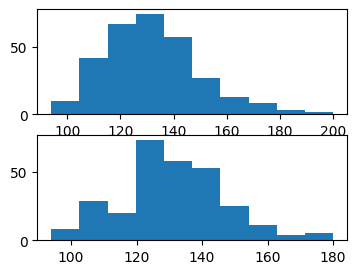

In [18]:
ax = plt.figure(figsize=(4,3)).subplots(2,1)
ax[0].hist(df.trtbps)
ax[1].hist(df_drop.trtbps)

Test de normalidad antes y después de eliminar outliers

In [19]:
from scipy.stats import shapiro

In [20]:
shapiro(df.trtbps)

ShapiroResult(statistic=0.9659166932106018, pvalue=1.4575286968465662e-06)

In [21]:
shapiro(df_drop.trtbps)

ShapiroResult(statistic=0.9778541326522827, pvalue=0.0002045066939899698)

La distribucion sigue sin ser normal después de eliminar los outliers. 

Vamos a aplicar una transformación boxcox para normalizar

In [22]:
df_boxcox= pd.Series(stats.boxcox(df.trtbps)[0])

In [23]:
shapiro(df_boxcox)

ShapiroResult(statistic=0.9911395907402039, pvalue=0.06516099721193314)

<AxesSubplot: >

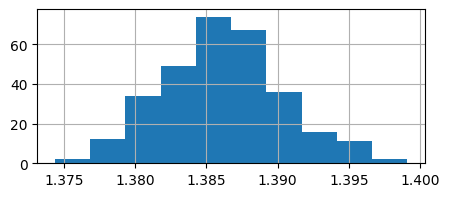

In [24]:
df_boxcox.hist(figsize=(5,2))

pvalue > 0.05. La distribución es normal.

In [25]:
df_drop_boxcox =  pd.Series(stats.boxcox(df_drop.trtbps)[0])

In [26]:
shapiro(df_drop_boxcox)

ShapiroResult(statistic=0.9897769689559937, pvalue=0.042366720736026764)

Sin embargo, si eliminamos los valores extremos y aplicamos boxcox, no conseguimos una distribución normal

<AxesSubplot: >

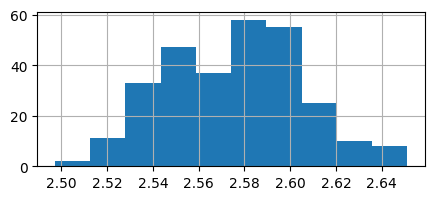

In [27]:
df_drop_boxcox.hist(figsize=(5,2))

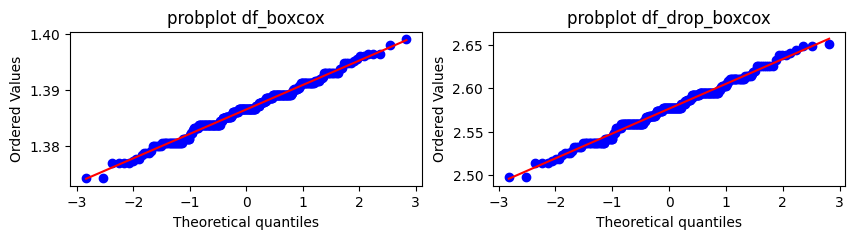

In [28]:
fig = plt.figure(figsize=(10, 2))
ax = fig.subplots(1,2)
stats.probplot(df_boxcox, plot=ax[0])
stats.probplot(df_drop_boxcox, plot=ax[1])
ax[0].set_title("probplot df_boxcox")
ax[1].set_title("probplot df_drop_boxcox")
plt.show()

Se observa en la grafica de probabilidad normal que al eliminar los datos atípicos, no conseguimos normalidad.

Vamos a normalizar los datos

c:\users\carlos\desktop\pra2\codigo\pra2\venv\lib\site-packages\scipy\stats\_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


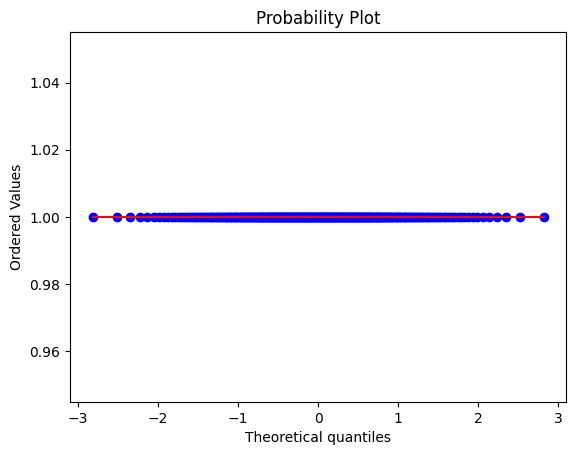

In [47]:
from sklearn.preprocessing import normalize

df_drop_norm = pd.DataFrame(normalize(df_drop[["trtbps"]]))

shapiro(df_drop_norm)

stats.probplot(df_drop_norm[0], plot=plt)
plt.show()